# ***Zero shot annotation using GroundingDINO***

Import libraries

In [55]:
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2
from matplotlib import pyplot as plt
import os
import shutil
import torch
import yaml
from tqdm import tqdm
import zipfile

# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define the prompt we are going to use

In [56]:
TEXT_PROMPT = 'head with a hard hat and safety glasses'
BOX_TRESHOLD = 0.5
TEXT_TRESHOLD = 0.25

Load the model and an image. Use a prompt to generate a caption and then use the caption to generate a bounding box with GroundingDINO.

final text_encoder_type: bert-base-uncased


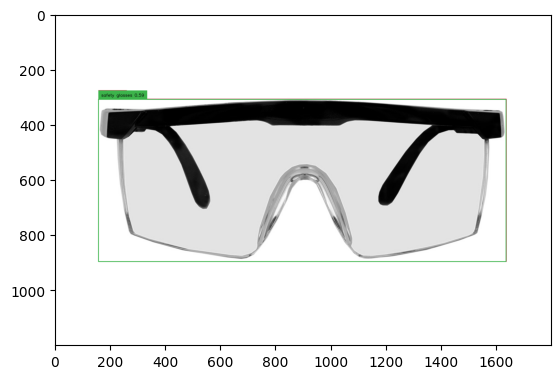

In [57]:
# load model
model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "GroundingDINO/weights/groundingdino_swint_ogc.pth")

# model to gpu
model.to(device)

# image to use
IMAGE_PATH = "simple_images/safety glasses/safety glasses_7.jpg"

# load image
image_source, image = load_image(IMAGE_PATH)

# move image to gpu
image.to(device)


boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

with torch.no_grad():
    # annotate the image
    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# show the image using opencv and matplotlib
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.show()


In [58]:
# Load the config file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Parse paths
input_folder = config['paths']['input_folder']
output_folder = config['paths']['output_folder']
image_folder =  config['paths']['image_folder']
annotation_folder =  config['paths']['annotation_folder']
output_temp_folder = config['paths']['output_temp_folder']
obj_train_data_folder = config['paths']['obj_train_data_folder']

# Parse classes
classes = config['classes']

Autonnate the images using the model.

In [59]:
# parameters
CLEAN_FOLDER = True
PLOT_IMAGES = False
BREAK_AFTER = 0 # if > 0, break after this many images
BOX_TRESHOLD = 0.5
TEXT_TRESHOLD = 0.25

# if clean folder is true, delete the output folder
if CLEAN_FOLDER and os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# if output folder does not exist, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    os.makedirs(image_folder)
    os.makedirs(annotation_folder)

# Manually generate the YAML structure
lines = [
    "path: safety",  # dataset root dir
    "train: images",
    "val: images",
    "",
    "# number of classes",
    f"nc: {len(classes)}",
    "",
    "# class names",
    "names: [" + ', '.join(f"'{cls}'" for cls in classes) + "]"
]

# Write the lines to a YAML file
with open(os.path.join(output_folder,"output.yaml"), "w") as outfile:
    outfile.write('\n'.join(lines))

# get all directories in input folder
directories = os.listdir(input_folder)

# iterate over all directories
for directory in directories:

    print('Processing directory:', directory)
    print('-'*10)

    # get all images in the input folder
    images = os.listdir(os.path.join(input_folder, directory))

    if BREAK_AFTER and len(images) > BREAK_AFTER:
        images = images[:BREAK_AFTER]

    # for each image in the input folder
    for idx, file in enumerate(tqdm(images)):

        # create the full input path and read the file
        input_path = os.path.join(input_folder, directory, file)
        image_source, image = load_image(input_path)

        # move image to gpu
        image.to(device)

        # for each class
        for class_name in classes:
            with torch.no_grad():
                
                # predict the bounding boxes, logits and phrases
                boxes, logits, phrases = predict(
                    model=model,
                    image=image,
                    caption=TEXT_PROMPT,
                    box_threshold=BOX_TRESHOLD,
                    text_threshold=TEXT_TRESHOLD
                )

                # modify phrases with classes names
                for c in classes:
                    for idx, p in enumerate(phrases):
                        if c in p:
                            phrases[idx] = c
        
        
        # if the model finds any bounding boxes
        if len(boxes) > 0:
            
            if PLOT_IMAGES:
                # create annotations show the image using opencv and matplotlib
                annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
                plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
                plt.show()

            # write the image to the image folder
            image_path = os.path.join(image_folder, file)
            cv2.imwrite(image_path, cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))

            # create the annotation file
            annotation_file = file.replace('.jpg', '.txt')
            annotation_path = os.path.join(annotation_folder, annotation_file)

            # open the annotation file
            with open(annotation_path, 'w') as f:
                
                # convert out phrases to indices
                out_phrases = [classes.index(s) for s in phrases]

                # for each bounding box
                for box, logits, phrase in zip(boxes, logits, out_phrases):
                    # write the bounding box to the file
                    f.write(f"{phrase} {box[0]} {box[1]} {box[2]} {box[3]}\n")
        
    

    

Processing directory: person
----------


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Processing directory: people
----------


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Processing directory: hard hat
----------


100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


Processing directory: safety glasses
----------


100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


Method implementation for zip folder with a progress bar

In [60]:
def zipdir(path, ziph, progress_bar):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in tqdm(files, unit="file", desc="Zipping"):
            full_path = os.path.join(root, file)
            relative_path = os.path.relpath(full_path, path)  # This will give you relative paths for zipped files
            ziph.write(full_path, relative_path)
            progress_bar.update(os.path.getsize(full_path))

Convert the yolo bounding box annotations to a YOLOV1 format zip file to be used in CVAT.

In [61]:
# zip files path
annotations_zip_path = os.path.join(os.path.dirname(output_temp_folder), 'annotations.zip')
images_zip_path = os.path.join(os.path.dirname(output_temp_folder), 'images.zip')

# if folder exists, delete it
if os.path.exists(output_temp_folder):
    shutil.rmtree(output_temp_folder)

# if zip exists, delete it
if os.path.exists(annotations_zip_path):
    os.remove(annotations_zip_path)
if os.path.exists(images_zip_path):
    os.remove(images_zip_path)

#########################
# obj_train_data folder #
#########################
os.makedirs(output_temp_folder)

# add a folder called obj_train_data
os.makedirs(obj_train_data_folder)

# get all files from the image folder
files = os.listdir(image_folder)

# list of all annoation paths
annotation_paths = [os.path.join('data/obj_train_data/', file) for file in files]

# save annotation paths to txt file
with open(os.path.join(output_temp_folder, "train.txt"), "w") as outfile:
    outfile.write('\n'.join(annotation_paths))

# get all files from the annotation folder
files = os.listdir(annotation_folder)

# copy all files in the annotation folder to the obj_train_data folder
for file in tqdm(files):
    shutil.copy(os.path.join(annotation_folder, file), os.path.join(obj_train_data_folder, file))

#########################
##### obj.data file #####
#########################

# Generate the content for the txt file
lines = [
    f"classes = {len(classes)}",
    "train = data/train.txt",
    "names = data/obj.names",
    "backup = backup/"
]

# Write the lines to a txt file
with open(os.path.join(output_temp_folder,"obj.data"), "w") as outfile:
    outfile.write('\n'.join(lines))

#########################
#### obj.names file #####
#########################
# Write the lines to a txt file
with open(os.path.join(output_temp_folder,"obj.names"), "w") as outfile:
    outfile.write('\n'.join(classes))


# zip the annotations
with tqdm(total=os.path.getsize(output_temp_folder), unit="B", unit_scale=True, desc="Zip Overall Progress", position=1, leave=True) as progress_overall:
    with zipfile.ZipFile(annotations_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir(output_temp_folder, zipf, progress_overall)

# zip the images
with tqdm(total=os.path.getsize(image_folder), unit="B", unit_scale=True, desc="Zip Overall Progress", position=1, leave=True) as progress_overall:
    with zipfile.ZipFile(images_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir(image_folder, zipf, progress_overall)

# delete safety_temp folder
shutil.rmtree(output_temp_folder)


Zipping: 100%|██████████| 13/13 [00:00<00:00, 4710.26file/s]
Zip Overall Progress:  51%|█████     | 2.09k/4.10k [00:00<00:00, 245kB/s]
Zipping: 100%|██████████| 13/13 [00:00<00:00, 170.62file/s]
Zip Overall Progress: 1.74MB [00:00, 22.1MB/s]                   
